<img src="images/escudo_utfsm.gif" style="float:right;height:100px">
<img src="images/IsotipoDIisocolor.png" style="float:left;height:100px">

<center>
<i><h2 style="font-family:serif;font-size:300%; text-align:center;color:#283A5B"> Tarea 3 - Pregunta 1</h2></i>
<h1 style="font-family:serif;font-size:180%; text-align:center;color:#4d4d4d"> <i> Redes Neuronales Artificiales (INF-395) - San Joaquín </i></h1>
<h3 style = 'font-family:serif;font-size:120%'><i> Ignacio Loayza C. 201273604-8</i></h3>
<h3 style = 'font-family:serif;font-size:120%'><i> Camilo Pérez P. 201273533-5</i></h3>
</center>

<p>
<center>Agosto 2018</center>
</p>

Partiremos por importar las librerías necesarias.

In [1]:
# encoding: utf-8

from keras.datasets import mnist
from keras.layers import Input, Dense, Activation, Dropout, Reshape
from keras.layers import Conv2D, MaxPool2D, Flatten, Conv2DTranspose, Reshape, UpSampling2D
from keras.layers import Lambda, LeakyReLU, BatchNormalization
from keras.models import Model, Sequential
from keras.metrics import mean_squared_error
from keras.optimizers import rmsprop
from keras import backend as K

import numpy

from scipy.stats import norm

from matplotlib import pyplot
%matplotlib inline

import seaborn

seaborn.set_style("darkgrid")

Using TensorFlow backend.


En esta ocasión revisaremos enfoques de aprendizaje no supervisado mediante VAEs y GANs, usando para esto el dataset MNIST nuevamente.

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
train_images, rows, cols = X_train.shape
test_images = X_test.shape[0]
X_train = X_train.reshape(train_images, rows, cols, 1).astype("float32")
X_test = X_test.reshape(test_images, rows, cols, 1).astype("float32")
X_train /= 255 # dejar todos los valores entre 0 y 1
X_test /= 255
rows, cols, channels = X_train.shape[1:]

# Parte 1: Autoencoders Variacionales

En primera instancia usaremos VAEs para generar nuevos datos a partir de lo ya presente en el dataset. Un VAE aprenderá la distribución latente de las imágenes de entrada en su parte de *encode* y luego generará imágenes nuevas mediante el *decode*, a diferencia de un AE normal que intentaría reconstruir la imagen original.

In [8]:
# cantidad de filtros convolucionales
filters = 32
# tamaño de kernel convolucional
num_conv = 3
latent_dim = 2
intermediate_dim = 128

# encoder
x = Input(shape = (rows, cols, channels))
conv_1 = Conv2D(filters, kernel_size = num_conv, padding = 'same', activation = 'relu')(x)
conv_2 = Conv2D(filters, kernel_size = num_conv, padding = 'same', activation = 'relu')(conv_1)
conv_3 = Conv2D(filters*2, kernel_size = num_conv, padding = 'same', activation = 'relu', strides = 2)(conv_2)
flat = Flatten()(conv_3)
hidden = Dense(intermediate_dim, activation = 'relu')(flat)
z_mean = Dense(latent_dim, activation = 'linear')(hidden)
z_log_var = Dense(latent_dim, activation = 'linear')(hidden)
encoder = Model(x, z_mean)
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1605760   
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total para

El encoder consiste de 3 capas convolucionales, seguidas de una capa densamente conectada antes de la capa de salida. Se usa la activación ReLU para todas las capas excepto la salida.

In [10]:
# crear capas del decoder
shape_before_flattening = K.int_shape(conv_3)[1:]
decoder_hid = Dense(intermediate_dim, activation = 'relu')
decoder_upsample = Dense(numpy.prod(shape_before_flattening), activation='relu')
decoder_reshape = Reshape(shape_before_flattening)
decoder_deconv_1 = Conv2DTranspose(filters, kernel_size = num_conv, padding = 'same', strides = 2, activation = 'relu')
decoder_deconv_2 = Conv2DTranspose(filters, kernel_size = num_conv, padding = 'same', activation = 'relu')
decoder_mean_squash = Conv2DTranspose(channels, kernel_size = num_conv, padding = 'same', activation = 'sigmoid')

La parte del decoder consiste en las capas "inversas" a las usadas anteriormente en el encoder. Se parte con una capa densamente conexa, luego se rearma la forma de los parámetros original (siendo `Reshape` la inversa de `Flatten`), y luego se hace pasar todo por tres capas de desconvolución (o convolución transpuesta).

Una convolución es esencialmente una transformación de una matriz grande a una matriz más pequeña, aplicando multiplicaciones de matrices sucesivas en submatrices de la más grande. El *stride* (paso) es la distancia a la que van a estar cada una de estas submatrices, definiendo así el tamaño de la matriz de salida.

<center><img width=500 src="images/normalconv.png"></center>

La convolución transpuesta es esencialmente el paso inverso. A partir de la matriz de kernel (usada como factor en cada submatriz de la convolución), se obtiene una matriz para la convolución transpuesta mediante trucos matemáticos, de forma que al aplicarla sobre cada elemento del resultado de la convolución se pueda obtener la matriz grande original.

<center><img width=500 src="images/transconv.png"></center>

In [11]:
# muestreo
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape = (K.shape(z_mean)[0], latent_dim), mean = 0., stddev = 1.)
    return z_mean + K.exp(z_log_var) * epsilon

# aplicar muestreo a salidas del encoder
z = Lambda(sampling, output_shape = (latent_dim,))([z_mean, z_log_var])
# armar decoder
hid_decoded = decoder_hid(z)
up_decoded = decoder_upsample(hid_decoded)
reshape_decoded =  decoder_reshape(up_decoded)
deconv_1_decoded = decoder_deconv_1(reshape_decoded)
x_decoded_relu = decoder_deconv_2(deconv_1_decoded)
x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)

vae = Model(x, x_decoded_mean_squash)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 28, 28, 32)   9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_2[0][0]                   
__________________________________________________________________________________________________
flatten_1 

El modelo completo consiste de... *hartas* capas, siendo la primera y la segunda mitad espejos de la otra. Primero va el encoder, dejando como salidas la media y la desviación estándar de la distribución. Al medio de la red va una capa Lambda que aplica muestreo a partir de esa distribución, y el resultado se lo pasa al decoder. Como el muestreo es aleatorio, se debiese generar una salida parecida a la entrada, pero no igual.

In [15]:
chosen_loss =  mean_squared_error(K.flatten(x),K.flatten(x_decoded_mean_squash))
reconstruction_loss = rows * cols * channels * chosen_loss
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis = -1)
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

Vamos a usar la función de pérdida especial vista en clases para los autoencoders variacionales. Esto es el resultado de maximizar la verosimilitud para el problema planteado, sin embargo, se le agrega la pérdida KL como regularizador. Esto es buena idea porque la función de esta pérdida es aproximar un poco más la distribución trabajada a una normal estándar. Parte del supuesto teórico es que ya lo es, pero en la práctica podremos observar una mejora en el desempeño de la red.

In [17]:
batch_size = 128
epochs = 10
vae.compile(optimizer = 'rmsprop')
hist = vae.fit(X_train, epochs = epochs, batch_size = batch_size, validation_data = (X_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 49s 815us/step - loss: 91.3811 - val_loss: 83.6604
Epoch 2/10
60000/60000 [==============================] - 31s 512us/step - loss: 78.4524 - val_loss: 77.8676
Epoch 3/10
60000/60000 [==============================] - 31s 512us/step - loss: 74.7079 - val_loss: 73.6296
Epoch 4/10
60000/60000 [==============================] - 31s 512us/step - loss: 72.3905 - val_loss: 72.5378
Epoch 5/10
60000/60000 [==============================] - 31s 512us/step - loss: 70.8159 - val_loss: 69.8487
Epoch 6/10
60000/60000 [==============================] - 31s 512us/step - loss: 69.6884 - val_loss: 69.6573
Epoch 7/10
60000/60000 [==============================] - 31s 512us/step - loss: 68.9128 - val_loss: 68.6186
Epoch 8/10
60000/60000 [==============================] - 31s 515us/step - loss: 68.2325 - val_loss: 69.6178
Epoch 9/10
60000/60000 [==============================] - 31s 515us/step - los

Parte de la demostración de la pérdida para VAEs termina apuntando a que el óptimo es usar MSE. Se observa una convergencia de pérdida bastante agradable, tanto para el conjunto de entrenamiento como para el de pruebas.

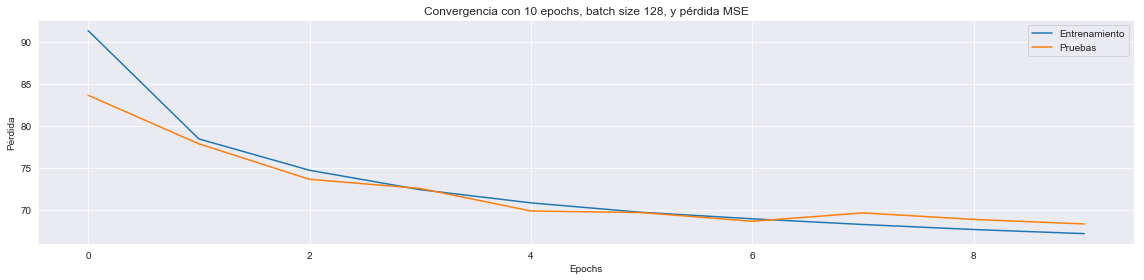

In [20]:
pyplot.figure(figsize = (16,4))
pyplot.plot(hist.history["loss"], label = "Entrenamiento")
pyplot.plot(hist.history["val_loss"], label = "Pruebas")
pyplot.xlabel("Epochs")
pyplot.ylabel("Pérdida")
pyplot.title("Convergencia con 10 epochs, batch size 128, y pérdida MSE")
pyplot.legend()
pyplot.tight_layout()
pyplot.show()

Podemos realizar una visualización de lo que pasa con las clases latentes. Grafiquemos las clases según su representación latente reconocida por el encoder, y veamos si es que forman *clusters* notables. Para esto le pediremos al encoder que codifique los datos de prueba, y luego colorearemos los puntos de cada clase según lo que digan las etiquetas de prueba.

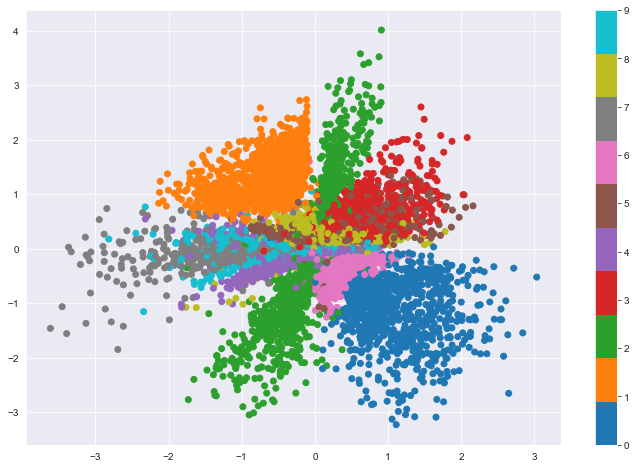

In [26]:
x_test_encoded = encoder.predict(X_test, batch_size = batch_size)

pyplot.figure(figsize = (12,8))
pyplot.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c = y_test, cmap = "tab10")
pyplot.colorbar()
pyplot.show()

Observamos que para el modelo, las clases 0 y 6 están muy cerca, implicando hay datos que podrían caer en una o en otra. Al centro hay una gran confusión entre las clases 3, 5, y 8, mientras que hacia la izquierda del diagrama se puede observar la similitud para el modelo entre los 7s y los 9s. Las clases 0, 1, 2, y 6 son las más reconocibles de forma inmediata por su media, puesto que forman los grupos más "puros".

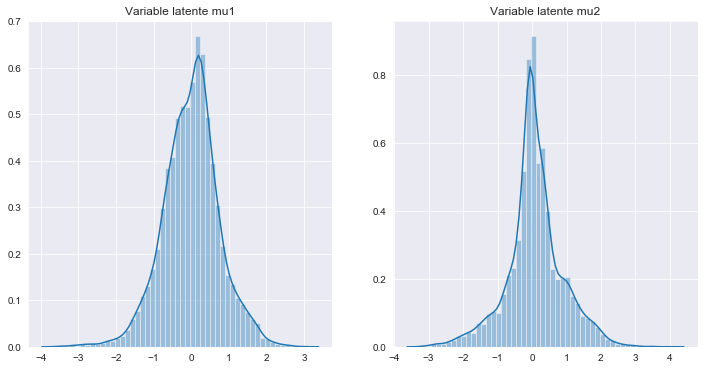

In [27]:
pyplot.figure(figsize = (12,6))
pyplot.subplot(1,2,1)
seaborn.distplot(x_test_encoded[:,0])
pyplot.title("Variable latente mu1")
pyplot.subplot(1,2,2)
seaborn.distplot(x_test_encoded[:,1])
pyplot.title("Variable latente mu2")
pyplot.show()

Podemos hacer lo mismo con el segundo conjunto de variables latentes, que representan la varianza de la distribución interna del encoder.

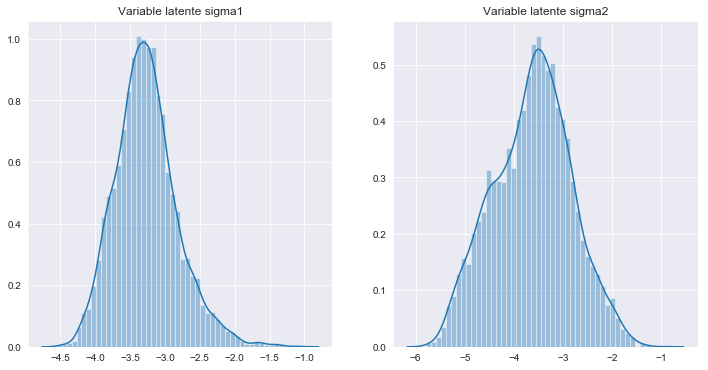

In [28]:
encoder_log_var = Model(x,z_log_var)

x_test_encoded_mkII = encoder_log_var.predict(X_test, batch_size = batch_size)
pyplot.figure(figsize = (12,6))
pyplot.subplot(1,2,1)
seaborn.distplot(x_test_encoded_mkII[:,0])
pyplot.title("Variable latente sigma1")
pyplot.subplot(1,2,2)
seaborn.distplot(x_test_encoded_mkII[:,1])
pyplot.title("Variable latente sigma2")
pyplot.show()

Sin embargo, esto está tomado como logvarianza. Al aplicar una exponencial debiese quedar la varianza real.

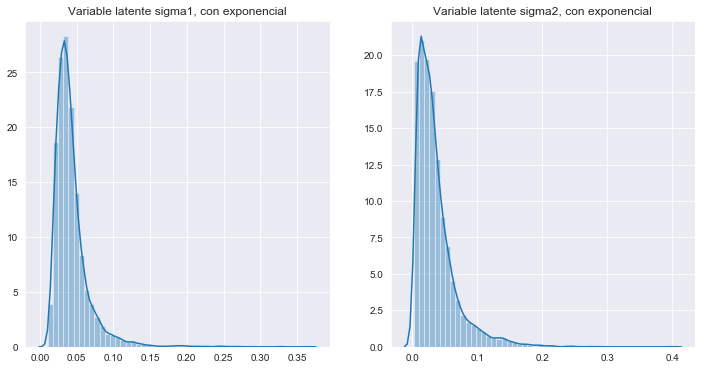

In [29]:
pyplot.figure(figsize = (12,6))
pyplot.subplot(1,2,1)
seaborn.distplot(numpy.exp(x_test_encoded_mkII[:,0]))
pyplot.title("Variable latente sigma1, con exponencial")
pyplot.subplot(1,2,2)
seaborn.distplot(numpy.exp(x_test_encoded_mkII[:,1]))
pyplot.title("Variable latente sigma2, con exponencial")
pyplot.show()

Ahora usemos el modelo para generar imágenes nuevas.

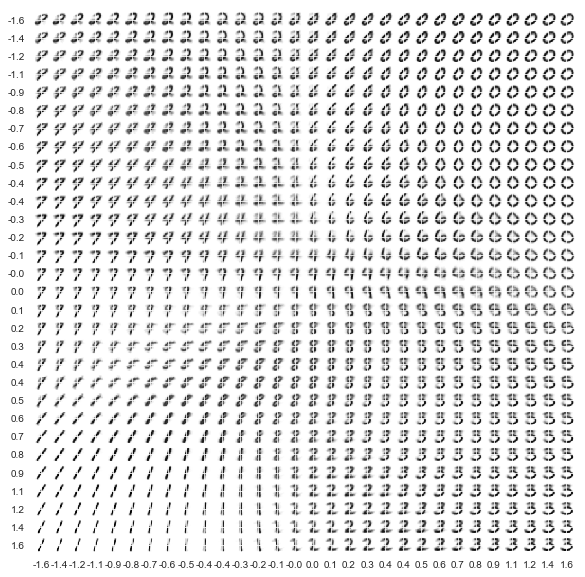

In [35]:
# generador
decoder_input = Input(shape = (latent_dim,))
_hid_decoded = decoder_hid(decoder_input)
_up_decoded = decoder_upsample(_hid_decoded)
_reshape_decoded = decoder_reshape(_up_decoded)
_deconv_1_decoded = decoder_deconv_1(_reshape_decoded)
_x_decoded_relu = decoder_deconv_2(_deconv_1_decoded)
_x_decoded_mean_squash = decoder_mean_squash(_x_decoded_relu)
generator = Model(decoder_input, _x_decoded_mean_squash)

# gráfico
n = 30
image_size = cols
figure = numpy.zeros((image_size * n, image_size * n))
# metodo de la transformada inversa
grid_x = norm.ppf(numpy.linspace(0.05, 0.95, n))
grid_y = norm.ppf(numpy.linspace(0.05, 0.95, n))
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = numpy.array([[xi, yi]])            
        x_decoded = generator.predict(z_sample, batch_size = batch_size)
        figure[i * image_size: (i + 1) * image_size,
               j * image_size: (j + 1) * image_size] = x_decoded[0][:,:,0]
pyplot.figure(figsize=(10, 10))
pyplot.imshow(figure, cmap = 'binary')
pos = numpy.arange(image_size/2, image_size*n, image_size)
pyplot.yticks(pos,numpy.round(grid_y,1))
pyplot.xticks(pos,numpy.round(grid_x,1))
pyplot.show()
# en los extremos del intervalo de confianza
grid = norm.ppf(numpy.linspace(0.000005, 0.999995, n))

También podría resultar de interés el cambiar la distribución latente de los datos. Es posible que una de las distribuciones "tipo normal" se apegue mejor a las características latentes reales de los datos, pero el modelo de los VAEs está matemáticamente definido en base a una distribución normal. Para poder obtener la forma en la que se debiese construir la arquitectura de la red considerando una distribución no normal, se deberían aplicar supuestos nuevos en la obtención de las funciones de pérdida y muestreo, y es posible que alguna activación deje de funcionar con el cambio de distribución.

Ahora, la gran gracia de usar una normal es que es fácil de trabajar, y es barato generar datos nuevos con una normal. Si se llegase a emplear una distribución distinta, podría generar datos de calidad, pero de forma muy poco eficiente.

Es notable también el hecho de que, con una gran cantidad de dimensiones latentes, el usar una distribución distinta no de resultados mejores que asumir una normal, debido al teorema del límite central.

Y hablando de la cantidad de dimensiones latentes, es razonable también asumir que con la normal estándar mejore el desempeño del VAE al aumentar éstas, pues tendremos mayor espacio para asumir parámetros. Para comprobar esto, correremos todo de nuevo.

In [36]:
# cantidad de filtros convolucionales
filters = 32
# tamaño de kernel convolucional
num_conv = 3
latent_dim = 4
intermediate_dim = 128

In [37]:
# encoder
x = Input(shape = (rows, cols, channels))
conv_1 = Conv2D(filters, kernel_size = num_conv, padding = 'same', activation = 'relu')(x)
conv_2 = Conv2D(filters, kernel_size = num_conv, padding = 'same', activation = 'relu')(conv_1)
conv_3 = Conv2D(filters*2, kernel_size = num_conv, padding = 'same', activation = 'relu', strides = 2)(conv_2)
flat = Flatten()(conv_3)
hidden = Dense(intermediate_dim, activation = 'relu')(flat)
z_mean = Dense(latent_dim, activation = 'linear')(hidden)
z_log_var = Dense(latent_dim, activation = 'linear')(hidden)
encoder = Model(x, z_mean)

In [38]:
# crear capas del decoder
shape_before_flattening = K.int_shape(conv_3)[1:]
decoder_hid = Dense(intermediate_dim, activation = 'relu')
decoder_upsample = Dense(numpy.prod(shape_before_flattening), activation='relu')
decoder_reshape = Reshape(shape_before_flattening)
decoder_deconv_1 = Conv2DTranspose(filters, kernel_size = num_conv, padding = 'same', strides = 2, activation = 'relu')
decoder_deconv_2 = Conv2DTranspose(filters, kernel_size = num_conv, padding = 'same', activation = 'relu')
decoder_mean_squash = Conv2DTranspose(channels, kernel_size = num_conv, padding = 'same', activation = 'sigmoid')

In [39]:
# aplicar muestreo a salidas del encoder
z = Lambda(sampling, output_shape = (latent_dim,))([z_mean, z_log_var])
# armar decoder
hid_decoded = decoder_hid(z)
up_decoded = decoder_upsample(hid_decoded)
reshape_decoded =  decoder_reshape(up_decoded)
deconv_1_decoded = decoder_deconv_1(reshape_decoded)
x_decoded_relu = decoder_deconv_2(deconv_1_decoded)
x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)

vae = Model(x, x_decoded_mean_squash)

In [40]:
chosen_loss =  mean_squared_error(K.flatten(x),K.flatten(x_decoded_mean_squash))
reconstruction_loss = rows * cols * channels * chosen_loss
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis = -1)
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

In [41]:
batch_size = 128
epochs = 10
vae.compile(optimizer = 'rmsprop')
hist = vae.fit(X_train, epochs = epochs, batch_size = batch_size, validation_data = (X_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 85s 1ms/step - loss: 2422.1668 - val_loss: 37.9876
Epoch 2/10
60000/60000 [==============================] - 31s 512us/step - loss: 33.5014 - val_loss: 31.5291
Epoch 3/10
60000/60000 [==============================] - 31s 511us/step - loss: 30.3541 - val_loss: 29.3828
Epoch 4/10
60000/60000 [==============================] - 31s 511us/step - loss: 28.9757 - val_loss: 29.2358
Epoch 5/10
60000/60000 [==============================] - 31s 512us/step - loss: 28.1029 - val_loss: 27.6026
Epoch 6/10
60000/60000 [==============================] - 31s 512us/step - loss: 27.4933 - val_loss: 27.5037
Epoch 7/10
60000/60000 [==============================] - 31s 512us/step - loss: 27.0412 - val_loss: 26.8550
Epoch 8/10
60000/60000 [==============================] - 31s 512us/step - loss: 26.6807 - val_loss: 26.7905
Epoch 9/10
60000/60000 [==============================] - 31s 512us/step - los

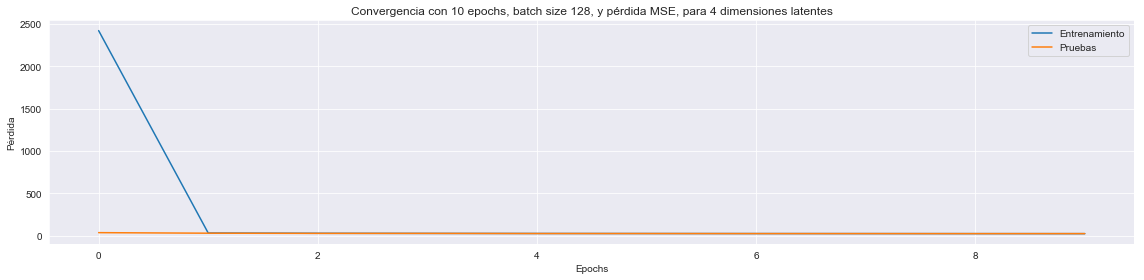

In [42]:
pyplot.figure(figsize = (16,4))
pyplot.plot(hist.history["loss"], label = "Entrenamiento")
pyplot.plot(hist.history["val_loss"], label = "Pruebas")
pyplot.xlabel("Epochs")
pyplot.ylabel("Pérdida")
pyplot.title("Convergencia con 10 epochs, batch size 128, y pérdida MSE, para 4 dimensiones latentes")
pyplot.legend()
pyplot.tight_layout()
pyplot.show()

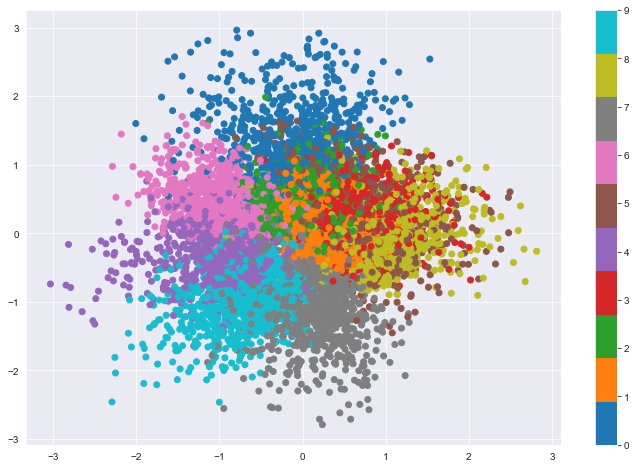

In [43]:
x_test_encoded = encoder.predict(X_test, batch_size = batch_size)

pyplot.figure(figsize = (12,8))
pyplot.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c = y_test, cmap = "tab10")
pyplot.colorbar()
pyplot.show()

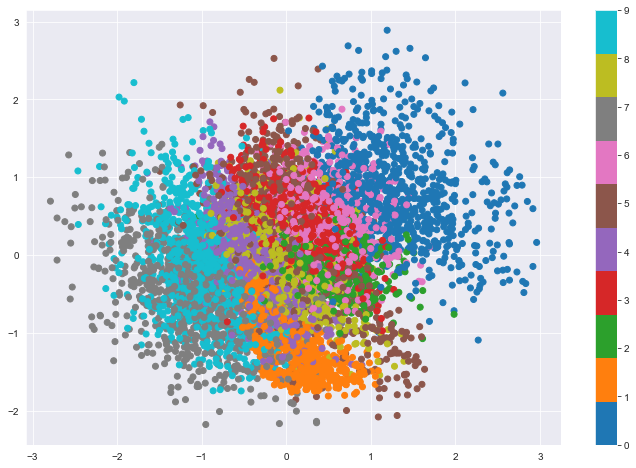

In [45]:
pyplot.figure(figsize = (12,8))
pyplot.scatter(x_test_encoded[:, 1], x_test_encoded[:, 2], c = y_test, cmap = "tab10")
pyplot.colorbar()
pyplot.show()

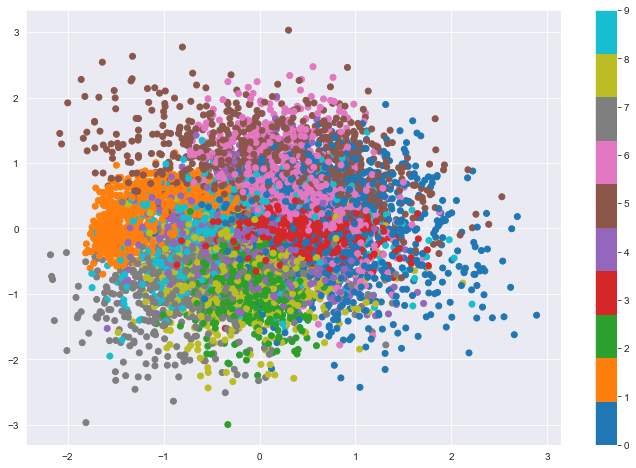

In [46]:
pyplot.figure(figsize = (12,8))
pyplot.scatter(x_test_encoded[:, 2], x_test_encoded[:, 3], c = y_test, cmap = "tab10")
pyplot.colorbar()
pyplot.show()

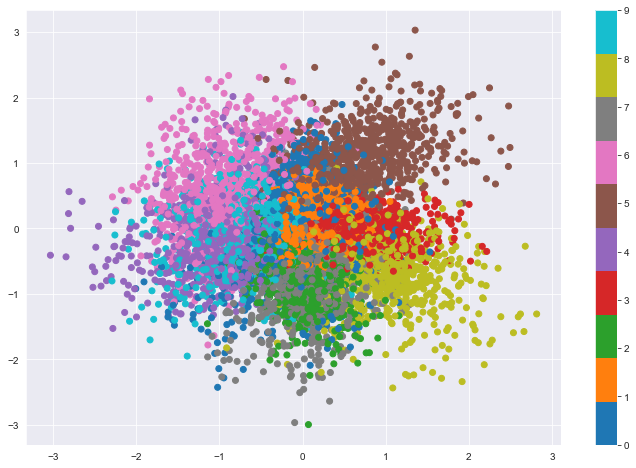

In [47]:
pyplot.figure(figsize = (12,8))
pyplot.scatter(x_test_encoded[:, 0], x_test_encoded[:, 3], c = y_test, cmap = "tab10")
pyplot.colorbar()
pyplot.show()

De forma contraria a nuestras expectativas, el desempeño de la red parece haber empeorado. Sin embargo, esto puede ser por las gráficas, puesto que al modelar en 4 dimensiones no somos capaces de apreciar el todo. Si bien algunas correlaciones entre dimensiones parecen verse caóticas (como el gráfico de inmediatamente arriba), basta con observar una nube clara en cualquiera de los gráficos para tener una idea potente de que la red es capaz de distinguir entre números. Por ejemplo, con las dimensiones 1 y 4 hay un reconocimiento claro de los 8s, mientras que los 7s se pueden apreciar de forma clara con las dimensiones 1 y 2.

Es enteramente posible que el desempeño de la red no haya cambiado, pero seguimos fieles a la hipótesis de que en realidad es mejor.

Finalmente, reintentemos todo pero con una modificación. El modelo no sobreajusta demasiado, de forma que agregar Dropout podría no ser de tanto interés como intentar otra cosa. Uno podría pensar que no es necesario tener tantas capas para un problema chico, veamos qué sucede al eliminar una.

In [3]:
# cantidad de filtros convolucionales
filters = 32
# tamaño de kernel convolucional
num_conv = 3
latent_dim = 2
intermediate_dim = 128

In [4]:
# encoder
x = Input(shape = (rows, cols, channels))
conv_1 = Conv2D(filters, kernel_size = num_conv, padding = 'same', activation = 'relu')(x)
conv_3 = Conv2D(filters*2, kernel_size = num_conv, padding = 'same', activation = 'relu', strides = 2)(conv_1)
flat = Flatten()(conv_3)
hidden = Dense(intermediate_dim, activation = 'relu')(flat)
z_mean = Dense(latent_dim, activation = 'linear')(hidden)
z_log_var = Dense(latent_dim, activation = 'linear')(hidden)
encoder = Model(x, z_mean)

encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1605760   
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total params: 1,624,834
Trainable params: 1,624,834
Non-trainable params: 0
_________________________________________________________________


In [5]:
# crear capas del decoder
shape_before_flattening = K.int_shape(conv_3)[1:]
decoder_hid = Dense(intermediate_dim, activation = 'relu')
decoder_upsample = Dense(numpy.prod(shape_before_flattening), activation='relu')
decoder_reshape = Reshape(shape_before_flattening)
decoder_deconv_1 = Conv2DTranspose(filters, kernel_size = num_conv, padding = 'same', strides = 2, activation = 'relu')
decoder_mean_squash = Conv2DTranspose(channels, kernel_size = num_conv, padding = 'same', activation = 'sigmoid')

In [6]:
# muestreo
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape = (K.shape(z_mean)[0], latent_dim), mean = 0., stddev = 1.)
    return z_mean + K.exp(z_log_var) * epsilon

# aplicar muestreo a salidas del encoder
z = Lambda(sampling, output_shape = (latent_dim,))([z_mean, z_log_var])
# armar decoder
hid_decoded = decoder_hid(z)
up_decoded = decoder_upsample(hid_decoded)
reshape_decoded =  decoder_reshape(up_decoded)
deconv_1_decoded = decoder_deconv_1(reshape_decoded)
x_decoded_mean_squash = decoder_mean_squash(deconv_1_decoded)

vae = Model(x, x_decoded_mean_squash)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 12544)        0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
dense_1 (D

In [7]:
chosen_loss =  mean_squared_error(K.flatten(x),K.flatten(x_decoded_mean_squash))
reconstruction_loss = rows * cols * channels * chosen_loss
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis = -1)
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

In [8]:
batch_size = 128
epochs = 10
vae.compile(optimizer = 'rmsprop')
hist = vae.fit(X_train, epochs = epochs, batch_size = batch_size, validation_data = (X_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 28s 472us/step - loss: 46.3333 - val_loss: 39.9250
Epoch 2/10
60000/60000 [==============================] - 21s 358us/step - loss: 38.9509 - val_loss: 37.4326
Epoch 3/10
60000/60000 [==============================] - 21s 358us/step - loss: 37.1608 - val_loss: 36.9447
Epoch 4/10
60000/60000 [==============================] - 22s 358us/step - loss: 36.1897 - val_loss: 35.6683
Epoch 5/10
60000/60000 [==============================] - 21s 358us/step - loss: 35.5767 - val_loss: 35.3950
Epoch 6/10
60000/60000 [==============================] - 21s 358us/step - loss: 35.0840 - val_loss: 35.0346
Epoch 7/10
60000/60000 [==============================] - 22s 358us/step - loss: 34.7492 - val_loss: 34.7117
Epoch 8/10
60000/60000 [==============================] - 21s 358us/step - loss: 34.4604 - val_loss: 34.6348
Epoch 9/10
60000/60000 [==============================] - 21s 358us/step - los

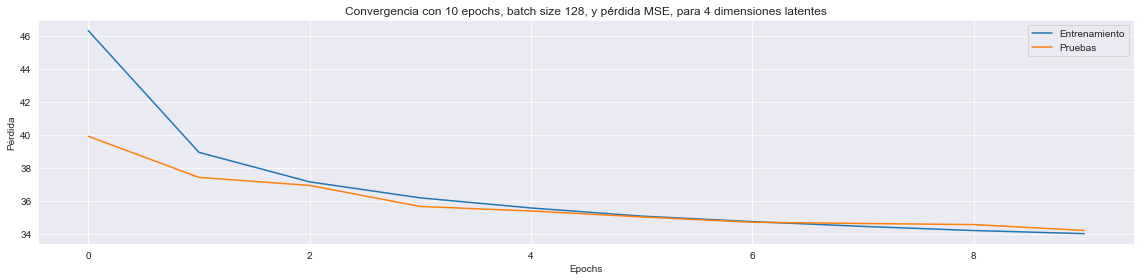

In [9]:
pyplot.figure(figsize = (16,4))
pyplot.plot(hist.history["loss"], label = "Entrenamiento")
pyplot.plot(hist.history["val_loss"], label = "Pruebas")
pyplot.xlabel("Epochs")
pyplot.ylabel("Pérdida")
pyplot.title("Convergencia con 10 epochs, batch size 128, y pérdida MSE, para 4 dimensiones latentes")
pyplot.legend()
pyplot.tight_layout()
pyplot.show()

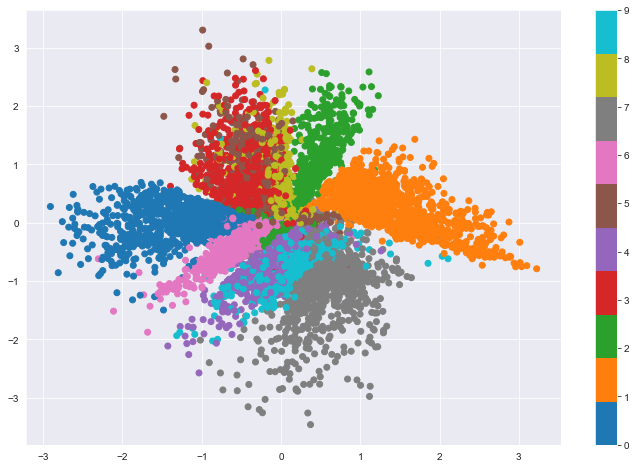

In [10]:
x_test_encoded = encoder.predict(X_test, batch_size = batch_size)

pyplot.figure(figsize = (12,8))
pyplot.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c = y_test, cmap = "tab10")
pyplot.colorbar()
pyplot.show()

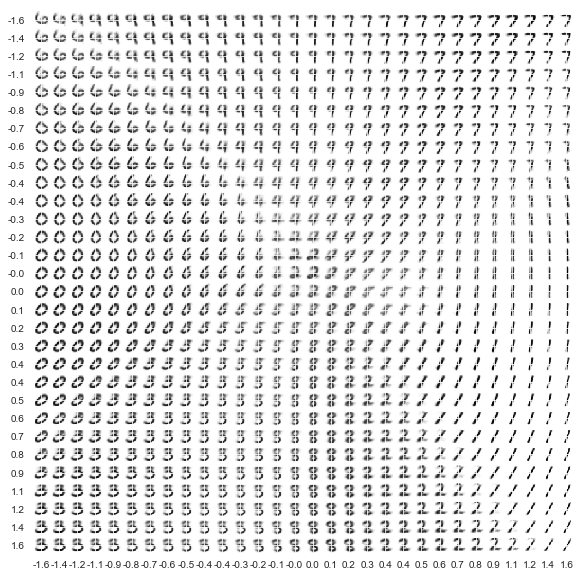

In [11]:
# generador
decoder_input = Input(shape = (latent_dim,))
_hid_decoded = decoder_hid(decoder_input)
_up_decoded = decoder_upsample(_hid_decoded)
_reshape_decoded = decoder_reshape(_up_decoded)
_deconv_1_decoded = decoder_deconv_1(_reshape_decoded)
_x_decoded_mean_squash = decoder_mean_squash(_deconv_1_decoded)
generator = Model(decoder_input, _x_decoded_mean_squash)

# gráfico
n = 30
image_size = cols
figure = numpy.zeros((image_size * n, image_size * n))
# metodo de la transformada inversa
grid_x = norm.ppf(numpy.linspace(0.05, 0.95, n))
grid_y = norm.ppf(numpy.linspace(0.05, 0.95, n))
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = numpy.array([[xi, yi]])            
        x_decoded = generator.predict(z_sample, batch_size = batch_size)
        figure[i * image_size: (i + 1) * image_size,
               j * image_size: (j + 1) * image_size] = x_decoded[0][:,:,0]
pyplot.figure(figsize=(10, 10))
pyplot.imshow(figure, cmap = 'binary')
pos = numpy.arange(image_size/2, image_size*n, image_size)
pyplot.yticks(pos,numpy.round(grid_y,1))
pyplot.xticks(pos,numpy.round(grid_x,1))
pyplot.show()
# en los extremos del intervalo de confianza
grid = norm.ppf(numpy.linspace(0.000005, 0.999995, n))

En la imagen de los números generados no se puede apreciar una baja fuerte en la calidad. Por otro lado, el mapa de las variables latentes tiene los grupos más claros que antes, identificando con mucha claridad todo menos los 4s y los 5s. Es posible que estemos frente a uno de esos casos donde "menos es más".

# Parte 2: Redes Adversarias Generativas

Ahora procederemos a intentar otro enfoque. Una GAN ataca el problema de codificación y decodificación como un juego, intentando alcanzar el equilibrio entre una red *generativa* y una *discriminativa*. La red generativa intenta crear datos que se parezcan lo más posible al *dataset* de entrenamiento, y la discriminativa intenta clasificar los datos que recibe en reales y falsos. Se dice que se alcanza el equilibrio cuando la red generativa ha aprendido la distribución de los datos perfectamente, de forma que la discriminativa ya no es capaz de hacer algo mejor que tirar una moneda.

In [3]:
dis = Sequential()
depth = 64
dropout = 0.4
input_shape = (rows, cols, channels)
dis.add(Conv2D(depth*1, (5,5), strides = 2, input_shape = input_shape, padding = 'same'))
dis.add(LeakyReLU(alpha = 0.2))
dis.add(Dropout(dropout))
dis.add(Conv2D(depth*2, (5,5), strides = 2, padding = 'same'))
dis.add(LeakyReLU(alpha = 0.2))
dis.add(Dropout(dropout))
dis.add(Conv2D(depth*4, (5,5), strides = 2, padding = 'same'))
dis.add(LeakyReLU(alpha = 0.2))
dis.add(Dropout(dropout))
dis.add(Flatten())
dis.add(Dense(1024))
dis.add(LeakyReLU(alpha = 0.2))
dis.add(Dense(1, activation = 'sigmoid'))
dis.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         819456    
__________

El modelo del discriminador en este caso consistirá de tres capas convolucionales con Dropout, seguidas de una capa para aplanar todo y dárselo como entrada a una capa densa oculta común y corriente. Todas las activaciones se harán mediante Leaky ReLU, puesto que la ReLU normal trunca los pesos negativos a cero, y esto se dice que "bloquea" los gradientes e impide que fluyan a través de la red. En GANs se ha observado que permitir el paso de un pequeño valor negativo ha dado buenos resultados, por lo que se usa la Leaky ReLU (implicando el término *leaky* que se está filtrando un poco de peso negativo en cada activación). Esto está enfocado a resolver el problema de la "muerte neuronal" de las células que usan ReLU, que pueden actualizarse de tal forma que nunca más se activan.

En términos análogos a la VAE, la red discriminadora será el encoder. Está observando entradas y generando parámetros latentes que codifican su entendimiento de la entrada.

In [4]:
gen = Sequential()
dim = 14
input_dim = 2 # para comparar con el VAE
gen.add(Dense(128, input_dim = input_dim))
gen.add(BatchNormalization())
gen.add(Activation('relu'))
gen.add(Dense(dim*dim*depth))
gen.add(BatchNormalization())
gen.add(Activation('relu'))
gen.add(Reshape((dim, dim, depth)))
gen.add(Conv2DTranspose(depth // 2, (3,3), padding = 'same', strides = (2,2)))
gen.add(BatchNormalization())
gen.add(Activation('relu'))
gen.add(Conv2DTranspose(depth // 2, (3,3), padding = 'same'))
gen.add(BatchNormalization())
gen.add(Activation('relu'))
gen.add(Conv2DTranspose(channels, (3,3), padding = 'same')) 
gen.add(Activation('sigmoid')) 
gen.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               384       
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 12544)             1618176   
_________________________________________________________________
batch_normalization_2 (Batch (None, 12544)             50176     
_________________________________________________________________
activation_2 (Activation)    (None, 12544)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 14, 14, 64)        0         
__________

Por otro lado, la red generadora será el análogo al decoder, implicando que su arquitectura debe espejar la discriminadora. Se partirá con una capa densa, y después de un Reshape, por 3 capas de desconvolución. Las activaciones en este caso serán ReLU comunes y corrientes, y para lidiar con las capas Dropout del discriminador se usará Batch Normalization.

Se puede argumentar que estas dos técnicas son capaces de hacer las veces de opuestos en algunos casos. Uno de los efectos que Dropout termina teniendo sobre la capa es que sesga la varianza de los pesos de una neurona, mientras que Batch Normalization los corrige mediante la normalización. Por lo tanto, no es loco pensar que podrían ir en esta arquitectura.

Generemos los modelos adversarios. Este tipo de redes requieren trucos especiales para su entrenamiento, uno de ellos es un enfoque iterativo en el que primero se deja fija una red y se entrena la otra, y luego viceversa. Con esto se logra emular el "juego" mencionado anteriormente.

In [5]:
## Discriminator model (police)
optimizer = rmsprop(lr = 0.0008, clipvalue = 1.0, decay = 6e-8)
dismod = Sequential()
dismod.add(dis)
dismod.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
# discriminador usa binary crossentropy porque su problema de clasificacion es binario

## Adversarial model
#dismod.trainable = False
optimizer = rmsprop(lr = 0.0004, clipvalue = 1.0, decay = 3e-8)
advmod = Sequential()
advmod.add(gen)
advmod.add(dis)
advmod.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

Ahora se procede al entrenamiento.

In [8]:
def train_on_steps(X_train, DM, AM, G, steps, batch_size):
    history = {"d":[],"g":[]}
    for e in range(steps):
        # Make generative images
        image_batch = X_train[numpy.random.randint(0, X_train.shape[0], size = batch_size),:,:,:] # sample images from real data
        noise_gen = numpy.random.uniform(-1, 1, size = [batch_size, input_dim]) # sample image from generated data
        generated_images = G.predict(noise_gen) # fake images
        # Train discriminator on generated images
        X = numpy.concatenate((image_batch, generated_images))
        # create labels
        y = numpy.ones([2*batch_size,1])
        y[batch_size:,:] = 0
        d_loss  = DM.train_on_batch(X,y)
        history["d"].append(d_loss)
        # train Generator-Discriminator stack on input noise to non-generated output class
        noise_tr = numpy.random.uniform(-1, 1, size = [batch_size, input_dim])
        y = numpy.ones([batch_size, 1])
        g_loss = AM.train_on_batch(noise_tr, y)
        history["g"].append(g_loss)
        if e % (steps//10) == 0:
            log_mesg = "%d: [D loss: %f, acc: %f]" % (e, d_loss[0], d_loss[1])
            log_mesg = "%s  [G loss: %f, acc: %f]" % (log_mesg, g_loss[0], g_loss[1])
            print(log_mesg)
    return history
    
train_steps = 5000
hist = train_on_steps(X_train, dismod, advmod, gen, train_steps, 64)

0: [D loss: 0.543707, acc: 0.687500]  [G loss: 0.861248, acc: 0.250000]
500: [D loss: 0.696942, acc: 0.625000]  [G loss: 2.881957, acc: 0.031250]
1000: [D loss: 0.535249, acc: 0.703125]  [G loss: 1.708787, acc: 0.125000]
1500: [D loss: 0.402265, acc: 0.789062]  [G loss: 0.169860, acc: 0.937500]
2000: [D loss: 0.475745, acc: 0.773438]  [G loss: 3.019123, acc: 0.125000]
2500: [D loss: 0.368375, acc: 0.828125]  [G loss: 0.289909, acc: 0.906250]
3000: [D loss: 0.329971, acc: 0.796875]  [G loss: 0.208435, acc: 0.937500]
3500: [D loss: 0.428836, acc: 0.781250]  [G loss: 1.630884, acc: 0.375000]
4000: [D loss: 0.306772, acc: 0.851562]  [G loss: 2.354856, acc: 0.406250]
4500: [D loss: 0.168152, acc: 0.929688]  [G loss: 0.657826, acc: 0.703125]


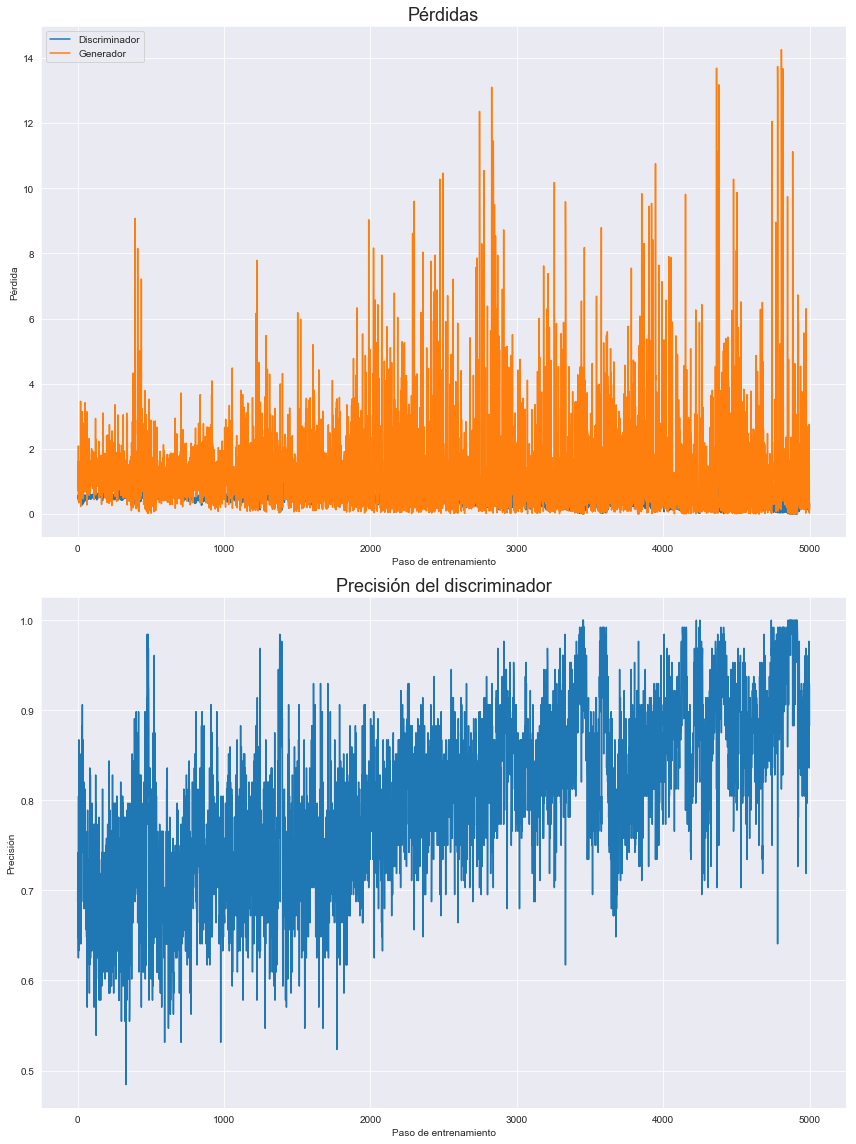

In [11]:
disLosses = [x for x,y in hist["d"]]
genLosses = [x for x,y in hist["g"]]
disAccs = [y for x,y in hist["d"]]

pyplot.figure(figsize = (12,16))

pyplot.subplot(2,1,1)
pyplot.plot(disLosses, label = "Discriminador")
pyplot.plot(genLosses, label = "Generador")
pyplot.ylabel("Pérdida")
pyplot.xlabel("Paso de entrenamiento")
pyplot.title("Pérdidas", fontsize = 18)
pyplot.legend()
pyplot.tight_layout()

pyplot.subplot(2,1,2)
pyplot.plot(disAccs)
pyplot.ylabel("Precisión")
pyplot.xlabel("Paso de entrenamiento")
pyplot.title("Precisión del discriminador", fontsize = 18)
pyplot.tight_layout()

pyplot.show()

Se nota de inmediato que hay problemas. El ideal para la precisión del discriminador debiese ser 0.5, sin embargo aquí estamos viendo que sube constantemente. Por otro lado, la pérdida del generador está muy por encima de la pérdida del discriminador. Esto quiere decir que el discriminador está aprendiendo más rápido que el generador, y por lo tanto, pasa a estar más veces en lo correcto que el generador, impiendo así que el generador aprenda.

Esto de todas formas es esperable en GANs vainilla, puesto que se conocen como inestables. Un mejor modelo es el DCGAN, o Deep Convolutional GAN.

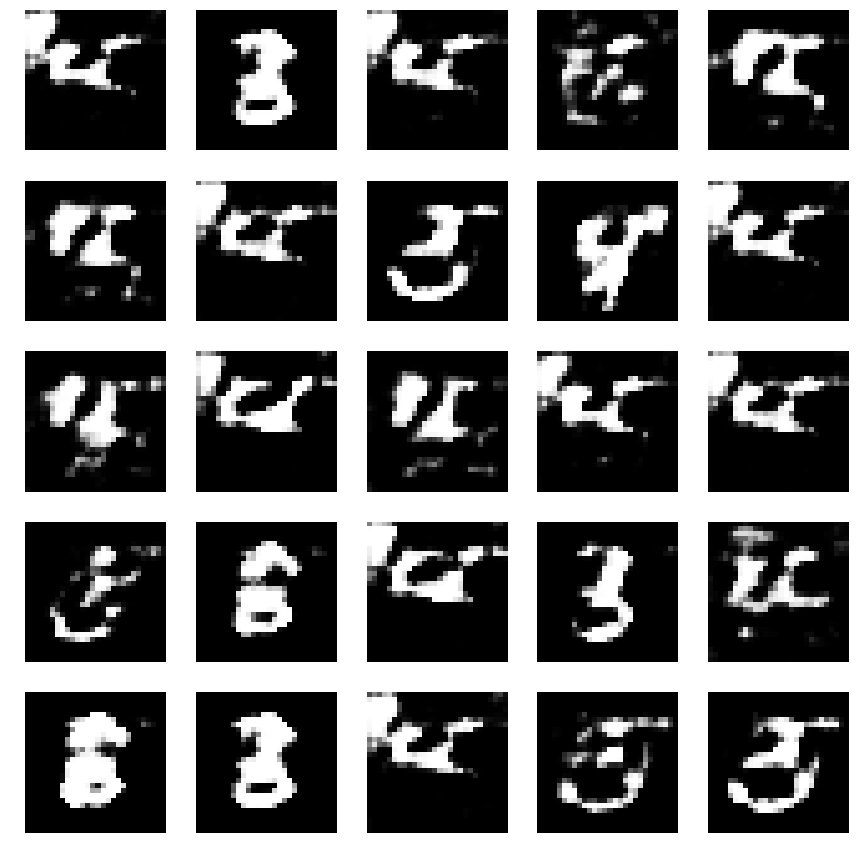

In [17]:
N = 25
noise = numpy.random.uniform(-1.0, 1.0, size = [N, input_dim]) 
images = gen.predict(noise)
pyplot.figure(figsize = (12,12))
for i in range(images.shape[0]):
    pyplot.subplot(5, 5, i+1)
    image = images[i, :, :, :]
    image = numpy.reshape(image, [rows, cols])
    pyplot.imshow(image, cmap = 'gray')
    pyplot.axis('off')
pyplot.tight_layout()
pyplot.show()

Aquí es donde se puede observar con claridad el mal entrenamiento del generador. Tiende siempre a irse por el mismo tipo de forma, con lo que le regala al discriminador los números que no se apeguen a esta (como el cero). Además la calidad de la forma no es la mejor, siendo la forma un híbrido mutante entre un 4 y un 9 con extremidades extra. En comparación, el VAE generaba muy claramente números en las partes "claras" de su espacio de variables latentes, sólo bajando su calidad cuando se encontraba entre dos grupos.

En términos de tiempos de entrenamiento, ambas máquinas se demoraron tiempos similares. Es probable que el VAE se demore más, puesto que se escogió la menor cantidad de epochs para entrenarla (y aún así dio mejores resultados!), tomando unos 10 minutos con 10 epochs. Para 5000 pasos, la GAN se demoró 15 minutos. Viendo sólo los resultados, es evidente que el VAE es superior en este caso de prueba.

En general, uno podría pensar que para generar mejores imágenes uno debería dedicarle igual cantidad de esfuerzo tanto al discriminador como al generador, al fin y al cabo el entrenamiento de uno depende del otro. En este caso en particular podría valer la pena intentar mejorar un poco el generador, puesto que el discriminador es claramente superior. Veamos qué pasa al cambiar el optimizador del generador, se han encontrado ejemplos donde se usa Adam en vez de RMSProp. La misma documentación de Keras sugiere que RMSProp funciona mejor en redes recurrentes.

Se han encontrado sugerencias también de que podría ser razonable modificar el discriminador, haciéndolo tropezarse en su entrenamiento mediante un *learning rate* más alto.

In [18]:
dis = Sequential()
depth = 64
dropout = 0.4
input_shape = (rows, cols, channels)
dis.add(Conv2D(depth*1, (5,5), strides = 2, input_shape = input_shape, padding = 'same'))
dis.add(LeakyReLU(alpha = 0.2))
dis.add(Dropout(dropout))
dis.add(Conv2D(depth*2, (5,5), strides = 2, padding = 'same'))
dis.add(LeakyReLU(alpha = 0.2))
dis.add(Dropout(dropout))
dis.add(Conv2D(depth*4, (5,5), strides = 2, padding = 'same'))
dis.add(LeakyReLU(alpha = 0.2))
dis.add(Dropout(dropout))
dis.add(Flatten())
dis.add(Dense(1024))
dis.add(LeakyReLU(alpha = 0.2))
dis.add(Dense(1, activation = 'sigmoid'))
dis.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 4, 4, 256)         819456    
__________

In [19]:
gen = Sequential()
dim = 14
input_dim = 2 # para comparar con el VAE
gen.add(Dense(128, input_dim = input_dim))
gen.add(BatchNormalization())
gen.add(Activation('relu'))
gen.add(Dense(dim*dim*depth))
gen.add(BatchNormalization())
gen.add(Activation('relu'))
gen.add(Reshape((dim, dim, depth)))
gen.add(Conv2DTranspose(depth // 2, (3,3), padding = 'same', strides = (2,2)))
gen.add(BatchNormalization())
gen.add(Activation('relu'))
gen.add(Conv2DTranspose(depth // 2, (3,3), padding = 'same'))
gen.add(BatchNormalization())
gen.add(Activation('relu'))
gen.add(Conv2DTranspose(channels, (3,3), padding = 'same')) 
gen.add(Activation('sigmoid')) 
gen.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 128)               384       
_________________________________________________________________
batch_normalization_5 (Batch (None, 128)               512       
_________________________________________________________________
activation_6 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 12544)             1618176   
_________________________________________________________________
batch_normalization_6 (Batch (None, 12544)             50176     
_________________________________________________________________
activation_7 (Activation)    (None, 12544)             0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 14, 14, 64)        0         
__________

In [20]:
## Discriminator model (police)
optimizer = rmsprop(lr = 0.0008, clipvalue = 1.0, decay = 6e-8)
dismod = Sequential()
dismod.add(dis)
dismod.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
# discriminador usa binary crossentropy porque su problema de clasificacion es binario

from keras.optimizers import Adam

## Adversarial model
optimizer = Adam(lr = 0.0004, clipvalue = 1.0, decay = 3e-8)
advmod = Sequential()
advmod.add(gen)
advmod.add(dis)
advmod.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

In [21]:
train_steps = 5000
hist = train_on_steps(X_train, dismod, advmod, gen, train_steps, 64)

0: [D loss: 0.697742, acc: 0.390625]  [G loss: 2.837604, acc: 0.000000]
500: [D loss: 0.514746, acc: 0.765625]  [G loss: 0.858961, acc: 0.500000]
1000: [D loss: 0.511777, acc: 0.820312]  [G loss: 0.311884, acc: 0.875000]
1500: [D loss: 0.294397, acc: 0.882812]  [G loss: 0.308185, acc: 0.859375]
2000: [D loss: 0.524185, acc: 0.867188]  [G loss: 0.116273, acc: 0.953125]
2500: [D loss: 0.059955, acc: 0.960938]  [G loss: 0.760350, acc: 0.609375]
3000: [D loss: 0.577118, acc: 0.882812]  [G loss: 1.342996, acc: 0.828125]
3500: [D loss: 5.419679, acc: 0.656250]  [G loss: 0.000000, acc: 1.000000]
4000: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]
4500: [D loss: 7.971192, acc: 0.500000]  [G loss: 0.000000, acc: 1.000000]


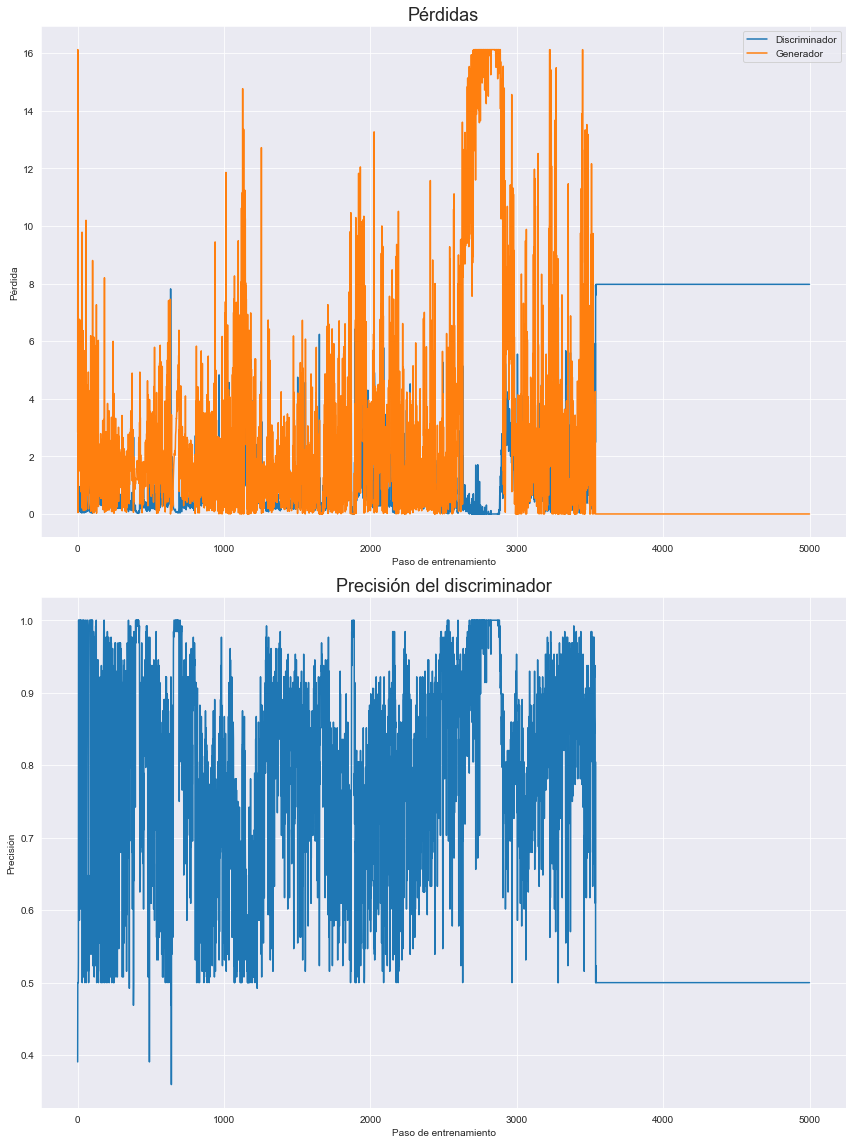

In [22]:
disLosses = [x for x,y in hist["d"]]
genLosses = [x for x,y in hist["g"]]
disAccs = [y for x,y in hist["d"]]

pyplot.figure(figsize = (12,16))

pyplot.subplot(2,1,1)
pyplot.plot(disLosses, label = "Discriminador")
pyplot.plot(genLosses, label = "Generador")
pyplot.ylabel("Pérdida")
pyplot.xlabel("Paso de entrenamiento")
pyplot.title("Pérdidas", fontsize = 18)
pyplot.legend()
pyplot.tight_layout()

pyplot.subplot(2,1,2)
pyplot.plot(disAccs)
pyplot.ylabel("Precisión")
pyplot.xlabel("Paso de entrenamiento")
pyplot.title("Precisión del discriminador", fontsize = 18)
pyplot.tight_layout()

pyplot.show()

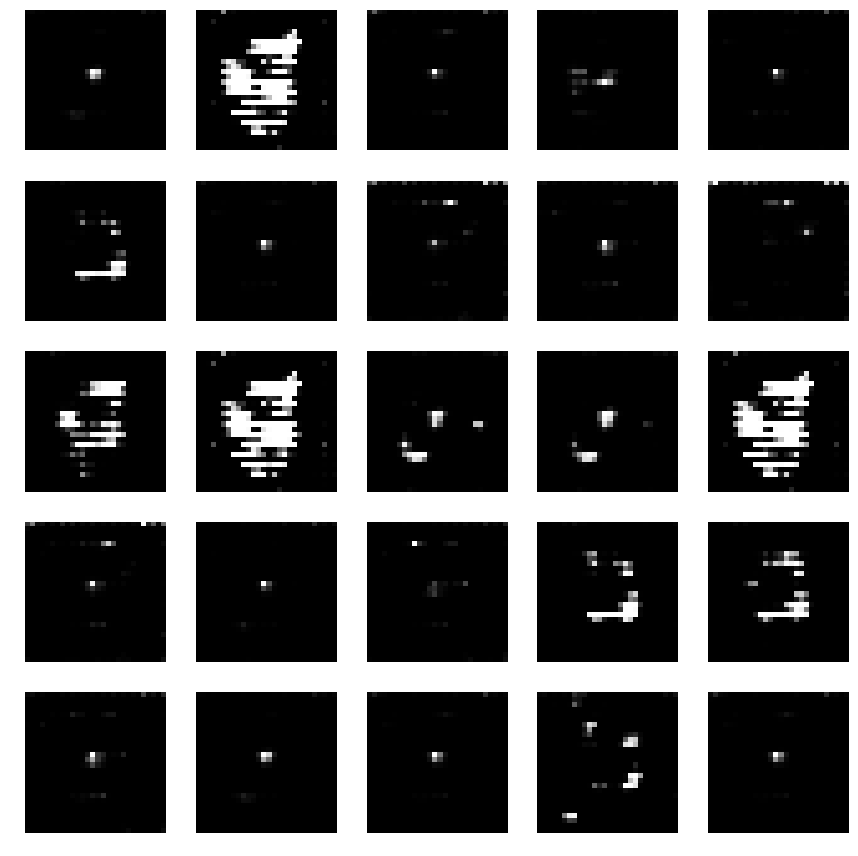

In [23]:
N = 25
noise = numpy.random.uniform(-1.0, 1.0, size = [N, input_dim]) 
images = gen.predict(noise)
pyplot.figure(figsize = (12,12))
for i in range(images.shape[0]):
    pyplot.subplot(5, 5, i+1)
    image = images[i, :, :, :]
    image = numpy.reshape(image, [rows, cols])
    pyplot.imshow(image, cmap = 'gray')
    pyplot.axis('off')
pyplot.tight_layout()
pyplot.show()